In [15]:
import pandas as pd
from sklearn import linear_model
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model,ensemble,metrics,preprocessing
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [16]:
df = pd.read_csv('/Users/richardknoche/Desktop/MainImages.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df.dropna()

df = df[df['Duration']>0]
df['Duration'] = df['Duration']-df['Duration'].min()

#Randomize the data
df = df.sample(frac=1,random_state=102)

In [17]:
df['Duration'].median()

2591944.0

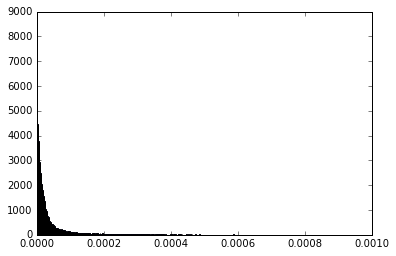

In [18]:
#Make CDF and figure out threshold for "top_x_percent"
count,edge,img = plt.hist(df['view_rate'],bins=np.linspace(0,0.001,500))
cdf = count.cumsum()/count.sum()
center = (edge[:-1]+edge[1:])/2

percentiles = [0.25,0.5,0.75]
thresh_indices = []
for percent in percentiles:
    thresh_indices.append(len(cdf[cdf< percent])) 


In [19]:
#Make percentile labels
labels = np.append([0],(np.array(percentiles)*100).astype(int))

def CalcPercentile(row):
    percentile_truth = ( row['view_rate'] > np.append(0,center[thresh_indices])) #is it greater than a mark or not
    pecentile_label = 100-max(percentile_truth * labels) #100 - maximum percentile mark that the number falls below (top x% of views)
    return pecentile_label 

df['Percentile'] = df.apply(CalcPercentile,axis=1)

In [20]:
#Creating Evenly sampled Training and Test sets
train = df.sample(frac = 0.6, random_state = 102)
test = df.drop(train.index)


In [21]:
#Not using categoricals for now
features = ['price','original_price','age', 'width', 'height',
       'depth', 'Num_Images', 'Duration', 
       'default_angle', 'Thirds_Horizontal_Value_Sym', 'Salient_Hue',
       'Complimentary_Color_Level', 'Thirds_To_Focal_Distance',
       'Vertical_Hue_Sym', 'Laplacian_Sharpness', 'Salient_Value',
       'Thirds_Horizontal_Saliency_Sym', 'Thirds_Value', 'Thirds_Sat',
       'B_Mean', 'V_var', 'Thirds_Saliency', 'g_ygrad', 'Busyness',
       'Horizontal_Saturation_Sym', 'Thirds_Vertical_Saliency_Sym', 'r_ygrad',
       'B_Width', 'g_xgrad', 'G_Mean', 'g_xgrad_std',
       'Thirds_Vertical_Hue_Sym', 'Thirds_Horizontal_Hue_Sym', 'Colorfulness',
       'Vertical_Value_Sym', 'R_xgrad', 'Horizontal_Value_Sym',
       'Salient_Saturation', 'standard_luminance', 'H_var',
       'Thirds_Vertical_Value_Sym', 'Number_of_Contours',
       'Thirds_Vertical_Saturation_Sym', 'R_Width', 'FFT_Sharpness',
       'b_xgrad_std', 'V_mean', 'b_ygrad', 'R_Mean',
       'Thirds_Horizontal_Saturation_Sym', 'b_xgrad', 'H_mean', 'r_ygrad_std',
       'Histogram_Darkness', 'g_ygrad_std', 'Thirds_Hue', 'S_mean', 'S_var',
       'G_Width', 'Lapacian_Saturation', 'percieved_luminace', 'b_ygrad_std',
       'r_xgrad_std', 'Horizontal_Hue_Sym', 'Vertical_Saturation_Sym',
       'Lapacian_Value', 'Lapacian_Hue']




train_x = train[features]
test_x = test[features]

lb = preprocessing.LabelBinarizer()
train_y = train['Percentile'].astype(str)
train_y = lb.fit_transform(train_y)
test_y = test['Percentile'].astype(str)
test_y = lb.fit_transform(test_y)


#Normalize features
train_std_scale = preprocessing.StandardScaler().fit(train_x)
train_x_std = train_std_scale.transform(train_x)

train_minmax_scale = preprocessing.MinMaxScaler().fit(train_x)
train_x_minmax = train_minmax_scale.transform(train_x)

test_std_scale = preprocessing.StandardScaler().fit(test_x)
test_x_std = test_std_scale.transform(test_x)

test_minmax_scale = preprocessing.MinMaxScaler().fit(test_x)
test_x_minmax = test_minmax_scale.transform(test_x)

train_x_features = train_x_std
test_x_features = test_x_std

#cv_x = cv[features]
#cv_y = cv['view_rate']

In [25]:
train_y.shape

(34844, 4)

In [27]:
#Train model
clf = OneVsRestClassifier(ensemble.AdaBoostClassifier()).fit(train_x, train_y)
#clf = ensemble.RandomForestClassifier().fit(train_x_features, train_y)


In [28]:
#Accuracy, Precision, Recall
predicted_y = clf.predict(test_x) 
print('Accuracy: ',clf.score(test_x_features,test_y))

precision, recall, fscore, support = metrics.precision_recall_fscore_support(test_y, predicted_y)
classifier_metrics = pd.DataFrame( {'Precision' : precision, 'Recall' : recall, 'F-Score' : fscore, 'Support' : support})
classifier_metrics.index=['Top 0-25%','Top 25-50%','Top 50-75%','Top 75-100%']
classifier_metrics

Accuracy:  0.230100305652


,F-Score,Precision,Recall,Support
Top 0-25%,0.706590,0.770423,0.652525,5940
Top 25-50%,0.780668,0.851680,0.720586,5873
Top 50-75%,0.384834,0.486044,0.318510,5959
Top 75-100%,0.167429,0.498638,0.100605,5457


In [29]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

rankings = []
for idx in range(len(features)):
    rankings.append(importances[indices[idx]])
    print("%d. %s %f" % (idx + 1, features[indices[idx]], importances[indices[idx]]))


AttributeError: 'OneVsRestClassifier' object has no attribute 'feature_importances_'

In [ ]:
sorted_importances = [importance for (importance,feature) in sorted(zip(importances,features),reverse=True)]
sorted_features = [feature for (importance,feature) in sorted(zip(importances,features),reverse=True)]


    
    
plt.figure(figsize=(10,18))
plt.title("Feature importances")
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color="r", align="center")
plt.yticks(range(len(sorted_features),0,-1))
ax=plt.gca()
ax.set_yticklabels(sorted_features)
plt.ylim([-1, len(sorted_features)+1])
plt.show()

In [ ]:
# Show that (hopefully) misclassificaitons are usually close the the correct class
# How many 4's get classified as 3's
# How many 3's get classified as 4's and 2's
# How

In [ ]:
#Maybe create an expectation value for the class using the probabilities

In [ ]:
#Try to identify the original images, and do this with those